
<center style ="font-size: x-large; font-weight: 600; line-height: 1.1;padding: 10px">
WEST Tokamak Electron Density Profile Modeled with a Cubic Spline and Infered from Interferometry with Bayesian Inference</center>  
<center>
Daniel Jordan
</center>
 
### Abstract:
<div style="text-align: justify; padding: 20px"> 
insert abstract here
</div>

#### Key words: Nuclear Fusion, Tokamak, Interferometry, Bayesian Inference, Cubic Splines

## Introduction
### Interferometry
Interferometry is a diagnostic technique commonly used in nuclear fusion devices to gain information about the plasma. Lasers traverse the plasm. The electron density alters refractive index of the plasma. This slows down the laser and causes a phase shift. It can be shown that the phase shift is proportional to the line integrated density of the electron density over the line of sight.

$$\Delta\phi = 2.82\times10^{-15} \lambda \int n_e dl$$

Where $\Delta\phi$ is the phase shift of the laser, $\lambda$ is the wavelength of the laser and $n_e$ is the electron density integrated over the entire line of sight of the laser. Using the measured phase shift and laser wavelength, interferometry devices report data of the line integrated density.

$$\int n_e dl = \frac{\Delta\phi}{2.82\times10^{-15} \lambda}$$

In the [WEST](https://west.cea.fr/en/Phocea/Vie_des_labos/Ast/ast_service.php?id_unit=330) device there are many lasers used. They are fired from the outer wall of the tokamak and reflected back from the inner wall for a double pass of the plasma, see Figure 1.

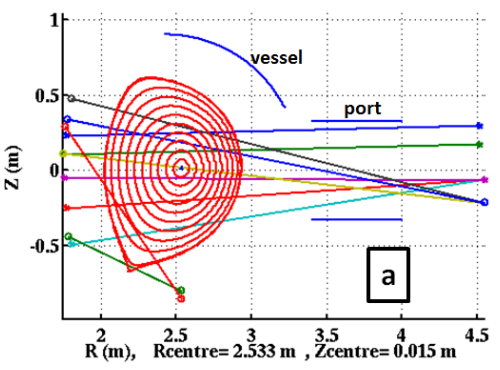
Figure 1: A diagram showing the cross section of the WEST tokamak. The red circles indicate magnetic flux surfaces. These are also surfaces of constant electron density. The colourd lines indicate the lines of sight of the interferometer lasers.

The electron density profile can be expressed in terms of the 2D axis $n_e(R,Z)$ or more elegantly in terms of $n_e(\rho)$. $R$ is the majour radial axis of the tokamak and Z the vertical axis. Where $n_e(\rho)$ is the electron density profile as a function of the normalised radious $\rho$. The electron density $(n_e)$ is known to be constant at magnetic flux surfaces, i.e. the red lines in figure 1. The normalised radious $\rho$ is 0 at the plasma center and 1 at the last closed magnetic flux surface. Every value of $\rho$ between corresponds to a different magnetic flux surface. Given infomation about the shape of the magnetic flux surfaces and $n_e(\rho)$ one can construct a complete plasma density profile, $n_e(R,Z)$. Thus the electron density profile is often expressed in one dimension along side the flux surfaces. Here is an example of a profile constructed with the NICE code at WEST and the corresponding flux surfaces.



In [4]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
from sampler_spline import sampler_spline_main
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


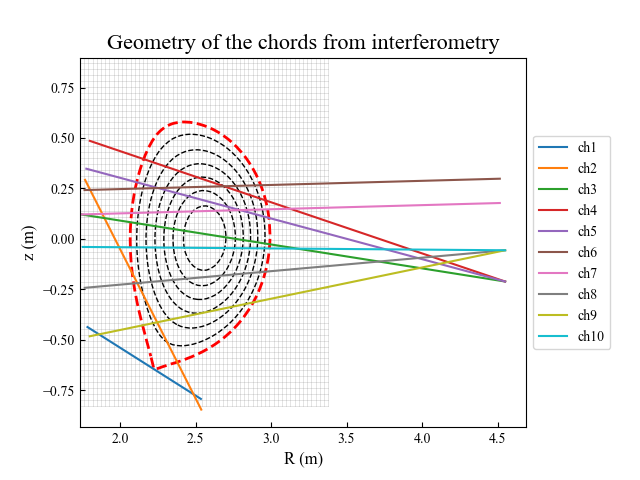

<IPython.core.display.Javascript object>


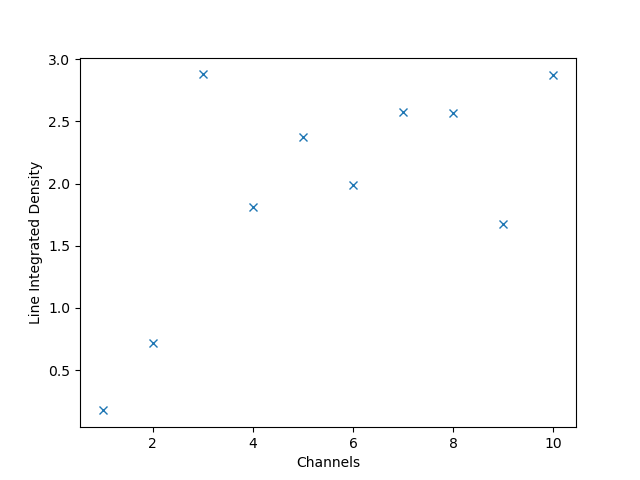

<IPython.core.display.Javascript object>


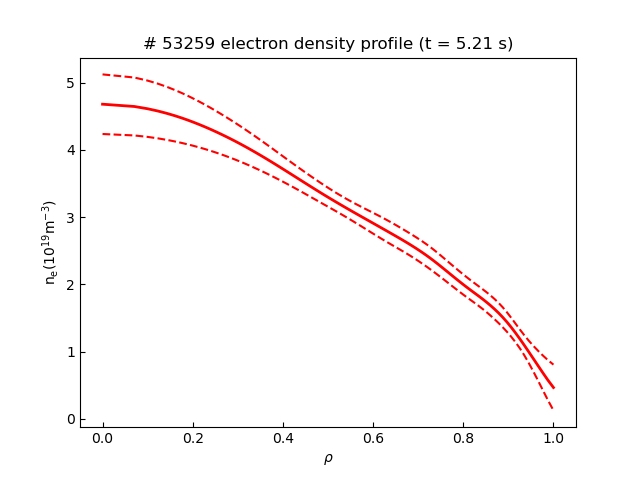

In [39]:
shot = 53259
t = 5.2113

geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}_occ1.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

figData = plt.figure()
plt.plot(interf.channels, interf.lid, 'x')
plt.xlabel('Channels')
plt.ylabel('Line Integrated Density')
plt.show()

dens_prof.plot_density_profile()

nice = dens_prof.dens_1d

# insert image here already made and saved in a folder near by

### Cubic Spline Function
This project uses a SciPy cubic spline to model the electron density profile, $n_e(\rho)$. The main paramaters for the function are a set of coordinates and then SciPy fits a cubic polynomial bwtween each point ensuring the curvature matches up at each point to get an overall smooth function. It is also possible to specify the gradient at the edges of the spline. Below shows a SciPy cubic spline fit to a random set of points, where the gradient at the left is set to 0.

<IPython.core.display.Javascript object>


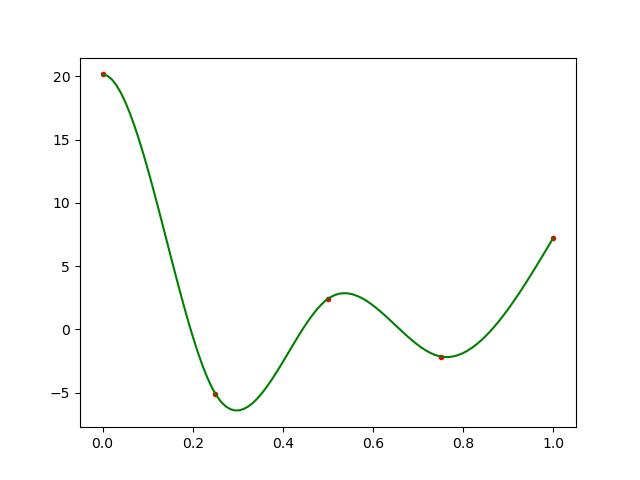

In [14]:
import numpy as np
randgen = np.random.default_rng(seed=49339389)
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

x = np.linspace(0,1,5)
y = randgen.normal(5,10,5)

spline = CubicSpline(x,y,bc_type=((1,0.0),(2,0.0)))

sx = np.linspace(0,1,100)
sy = spline(sx)
figSpline = plt.figure()
plt.plot(x,y, '.r',label='Origional Points')
plt.plot(sx,sy, '-g', label='Spline Fit')
plt.show()


The x-values of the points are commonly known as knots. In this project the y-values shall be known as spline values. 

### Bayesian Inference
Bayes' theorem is a powerful tool that can assess the relative propability of something being true given there is a collection of data about it. In the terms of this interferometry project, it can be expressed as,

$$P[n_e(\rho)|\vec d] = \frac{P[\vec d| n_e(\rho)] P[n_e(\rho)]}{P[\vec d]}$$.

The posterior, $P[n_e(\rho)|\vec d]$ represents the relative probability a specific density profile $n_e(\rho)$ is the true profile given a set of data $\vec d$. The data $\vec d$, is what is measured by interferometry and is subject to an experimental error. The posterior in general is not intuitive to know, but the likelyhood is. The likelyhood $P[\vec d|n_e(\rho)]$, is the probability of getting a set of data $D$ given a specific electron density profile. It can be expanded to show how it is a product of each individual measurement $d_i$,

$$P[\vec d|n_e(\rho)] = \prod_{i}^{m}P[d_i|n_e(\rho)].$$

The likelihood is influenced by the experimental error. In this project we assume a gaussian error and so the likelihood is simply,

$$P[d_i|n_e(\rho)] = Norm(d_i, mean=LID_i, sdv=\sigma_{er})$$.

To avoid precision errors it is more convenient to work with the log likelihood. When taking the log of the analytical form of each gaussian and summing them we get,

$$
\log \left(P[\vec d|n_e(\rho)]\right) = m \times \log\left(\frac{1}{\sigma_{er}\sqrt{2\pi}}\right) + \sum_{i=1}^{m} -\frac{1}{2} \frac{(d_i - LID_i)^2}{\sigma_{er}^2} 
$$

The $LID_i$ is the Line Integrated Desnsity that would be measured by an error free version of the interferometry device given the density profile $n_e(\rho)$ is the ground truth. $LID_{n_e(\rho)}$ can be computed with the forward model which is a small simulation of an error free version of the WEST interferometry device. The $P[\vec d]$ is the probability of data $\vec d$, and serves as a normalisation factor. It is ignored in this study and normalisation is achieved with other means. The $P[n_e(\rho)]$ is known as the prior distribution. It represents all knowledge of the plasma density profile before the experiment. This in in the form of assumed knowledge of the spline parameters. The number of knots $K$ is set at the begining. There will always be an edge knot at $\rho=1$ and its spline value will have a gaussian prior with a mean of 0. This contributes the prior knowledge that the electron density is near 0 at the edge. There will always be a core knot and the gradient at the core will have a Gaussian prior with a mean of 0. This contributes the prior knowledge that the profile is flat at the core, this enforces the known symmetry and continuity. The position of the other knots follow a uniform prior with the minimum being $\rho=0$ and maximum as $\rho=1$, thus covering the full space. The spline values also have a uniform prior with the minimum being 0 and the maximum being twice what was recorded by NICE, ?????. In the order each distribution was mentioned, the prior $P[n_e(\rho)]$ can thus be expressed as,

$$
P[n_e(\rho)] = Norm(edge\,spline\,value, mean=0, \sigma_{esv}) \times Norm(core\,grad\,value, mean=0, \sigma_{cgv}) \times (K-2)(1^{-1}) \times (2 NICEmax)^{-1}.
$$

Similiar to the likelihood using the logarithym helps avoid precision issues and then the prior is,

$$
\log\left(P[n_e(\rho)]\right) = \log\left(\frac{1}{\sigma_{esv}\sqrt{2\pi}}\right) -\frac{1}{2}\frac{(esv)^2}{\sigma_{esv}^2} + \log\left(\frac{1}{\sigma_{cgv}\sqrt{2\pi}}\right) -\frac{1}{2}\frac{(cgv)^2}{\sigma_{esv}^2} + \log(K-2) - \log(2\,NICEmax).
$$

The log posterior for a set of parameters and hyperparameters can be obtained by summing the log prior and log likelihood. For clarity I shall list the paramaters and hyperparameters:

Constants  
data, $\vec d$  
Edge Knot at $\rho=1$  
Core Knot at $\rho=0$  
  
Hyperparameters,    
Number of Knots, K  
Experimental Error, $\sigma_{er}$  
Standard Deviation of Edge Spline Value, $\sigma_{esv}$  
Standard Deviation of Core Gradient Value, $\sigma_{cgv}$  
Bounds of Knot Locations uniform prior [0,1]
Bounds of Spline Values uniform prior [0,10] 
  
Parameters,  
Knot Locations, uniform prior  
Spline Values, uniform prior  
Edge Spline Value, Gaussian prior  
Core Spline Gradient, Gaussian prior.  
  
The parameters that maximise the posterior are the ones that match the data without overfitting. Bayesian inference automatically deploys ocams razor allowing it to avoid overfitting [??]. Various optimisation algorythims can be deployed to find these parameters as will be explored. These parameters can be inputed into the cubic spline function to gain the electron density profile. In order to obtain an error for the inference the posterior can be sampled from. After many parameters are sampled from the posterior they can all be placed in the cubic spline function to gain many electron density profiles. The mean value of the sapled profiles for each $\rho$ should give the same result as the max posterior method. The 95% confidence limits can be found by calculating the 2.5 and 97.5 percentiles of the sampled profiles. Some sampling methods are more efficient than others. This project uses the python emcee package and its ensemble sampler. This requires a burn in period.

In [71]:
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

In [136]:
RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 

#geo is line geometry, equi are the fulxsurfaces equilibrium
R = compute_response_matrix(geo, equi, RHO)
SPLINE_VAL_UPPER = 10
d = interf.lid

# Hyperparamters
NKNOTS = 6
SIGer = 0.03
SIGesv = 0.1
SIGcgv = 0.1

BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,1) for i in range(NKNOTS-2)]+[(0,10) for i in range(NKNOTS-1)]

def Gen_init_params():
    initial_cgv = randgen.normal(0,SIGcgv)
    initial_esv = randgen.normal(0,SIGesv)
    initial_knot_locations = randgen.uniform(0,1,NKNOTS-2)
    initial_spline_values = randgen.uniform(0,SPLINE_VAL_UPPER,NKNOTS-1)

    #Core Gradient Value, Edge Spline Value, Knot Locations, Spline Values
    initial_params = np.array([initial_cgv,initial_esv]+list(initial_knot_locations)+list(initial_spline_values))
    return initial_params

initial_params = Gen_init_params()
    
def Profile(params):
    cgv, esv = params[0:2]
    knot_locations, spline_values = params[2:2+NKNOTS-2], params[2+NKNOTS-2:]
    all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])
    all_spline_values = np.block([spline_values,esv])
    
    #ensure unique to avoid error, x must be increasing
    if len(np.unique(all_knots))<len(all_knots):
        all_knots = all_knots + np.linspace(0,0.00001,len(all_knots))
    sort = np.argsort(all_knots)
#     print(len(knots))
#     print(sort)
#     print(len(np.block([spline_values[sort],esv])))
#     print(cgv)
    cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
    n_e = cubic_spline(RHO)
    return n_e

def Log_prior(params):
    cgv, esv = params[0:2]
    #check bounds
    within_bounds = True
    for i in range(len(params)):
        within_bounds = within_bounds and params[i] > BOUNDS[i][0] and params[i] < BOUNDS[i][1]
    if not within_bounds:
        return -np.inf    
    return -(esv**2 / SIGesv**2) - (cgv**2 / SIGcgv**2)

def Log_likelihood(params, d):
    n_e = Profile(params)
    LID = R @ n_e
    return np.sum(-(d - LID)**2 / SIGer**2)

def Log_posterior(params, d):
    log_prior = Log_prior(params)
    #
    if not np.isfinite(log_prior):
            return -np.inf
    else:
            return log_prior + Log_likelihood(params, d)

neg_log_post = lambda x: -Log_posterior(x,d)
# map with differential evolution
# results = differential_evolution(neg_log_post, BOUNDS)
# results = minimize(neg_log_post,initial_params)
# print(results)

<IPython.core.display.Javascript object>


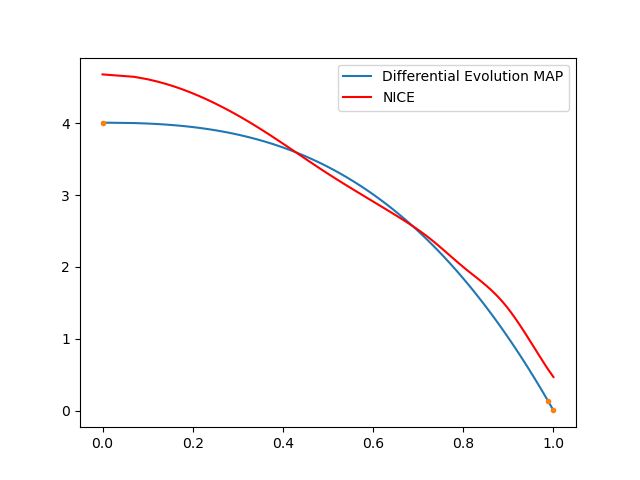

In [138]:
params_map=results.x
cgv, esv = params[0:2]
knot_locations, spline_values = params[2:2+NKNOTS-2], params[2+NKNOTS-2:]
all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])
all_spline_values = np.block([spline_values,esv])

figDifEv = plt.figure()
plt.plot(RHO,Profile(results.x),label='Differential Evolution MAP')
plt.plot(RHO,nice, 'r', label='NICE')
plt.plot(all_knots,all_spline_values,'.')
plt.legend()

In [144]:
import emcee
import time
from scipy import stats
from tqdm import tqdm

NBURN = 2000
NSAMPLES = 2000

def samples2profiles(samples):
    profiles = Profile(samples[0,:])
    prog_bar = tqdm(range(1,samples.shape[0])) 
    for i in prog_bar:
        profiles = np.block([[profiles],
                             [Profile(samples[i,:])]])
    return profiles
# mcmc
# Sampling

ndim = len(initial_params)
nwalkers = ndim * 6

params_start = initial_params
# params_start = params_map + 0.01 * np.random.randn(nwalkers, ndim)
for i in range(nwalkers-1):
    init_params = Gen_init_params()
    params_start = np.block([[params_start],
                             [init_params]])

print(np.linalg.cond(params_start))
    


28.085761684658426


In [140]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, neg_log_post)
print("MCMC sampling starts")
time1 = time.time()
print(type(initial_params))
print("Burn-in steps ...")
state = sampler.run_mcmc(x_start, NBURN, progress=True)
sampler.reset()
print('Sampling ...')
sampler.run_mcmc(state, NSAMPLES, progress=True, skip_initial_state_check=True)
time2 = time.time()
samples = sampler.get_chain(flat=True)
print(f'Sampling finished. Cost time: {time2 - time1} s')
print(f'Mapping free parameters to splines ...')


MCMC sampling starts
<class 'numpy.ndarray'>
Burn-in steps ...


100%|██████████| 2000/2000 [00:04<00:00, 423.65it/s]


Sampling ...


100%|██████████| 2000/2000 [00:04<00:00, 436.74it/s]

Sampling finished. Cost time: 9.332826614379883 s
Mapping free parameters to splines ...


In [ ]:
profiles = samples2profiles(samples)

In [150]:
print(f'Cost time: {time.time() - time2} s')
profiles_mean = profiles.mean(axis=0)
profiles_median = np.median(profiles, axis=0)
profiles_mode = stats.mode(profiles, axis=0, keepdims=False).mode.flatten()
profiles_lower = np.percentile(profiles, 25, axis=0)
profiles_upper = np.percentile(profiles, 75, axis=0)

100%|██████████| 59999/59999 [07:11<00:00, 138.98it/s] 


Cost time: 122780.94852590561 s


<IPython.core.display.Javascript object>


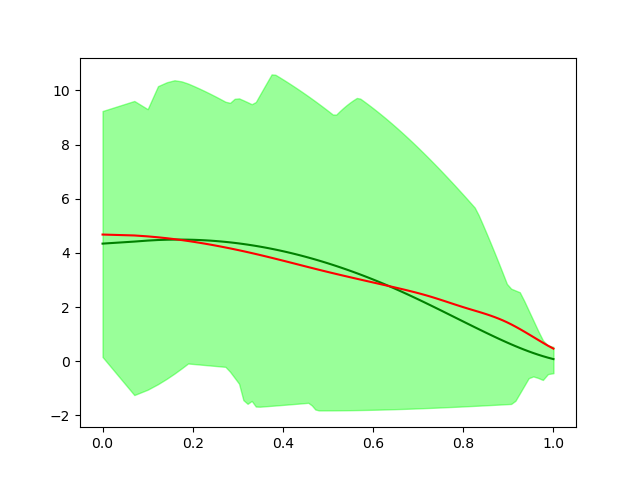

In [151]:
figMCMC = plt.figure()
plt.plot(RHO, profiles_mean, 'g')
plt.fill_between(RHO, profiles_lower, profiles_upper,color = (0,1,0,0.4))
plt.plot(RHO,nice, 'r')

# Different Approach

To incorperate smooth-ness I will use a MVG with a static kernel as the prior for the spline values, as well as an additional gaussian prior for the edge spline value. 

In [ ]:
RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 

#geo is line geometry, equi are the fulxsurfaces equilibrium
R = compute_response_matrix(geo, equi, RHO)
SPLINE_VAL_UPPER = 10
d = interf.lid

# Hyperparamters
NKNOTS = 6
SIGer = 0.03
SIGesv = 0.1
SIGcgv = 0.1

BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,1) for i in range(NKNOTS-2)]+[(0,10) for i in range(NKNOTS-1)]

def Gen_init_params():
    initial_cgv = randgen.normal(0,SIGcgv)
    initial_esv = randgen.normal(0,SIGesv)
    initial_knot_locations = randgen.uniform(0,1,NKNOTS-2)
    initial_spline_values = randgen.uniform(0,SPLINE_VAL_UPPER,NKNOTS-1)

    #Core Gradient Value, Edge Spline Value, Knot Locations, Spline Values
    initial_params = np.array([initial_cgv,initial_esv]+list(initial_knot_locations)+list(initial_spline_values))
    return initial_params

initial_params = Gen_init_params()
    
def Profile(params):
    cgv, esv = params[0:2]
    knot_locations, spline_values = params[2:2+NKNOTS-2], params[2+NKNOTS-2:]
    all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])
    all_spline_values = np.block([spline_values,esv])
    
    #ensure unique to avoid error, x must be increasing
    if len(np.unique(all_knots))<len(all_knots):
        all_knots = all_knots + np.linspace(0,0.00001,len(all_knots))
    sort = np.argsort(all_knots)
#     print(len(knots))
#     print(sort)
#     print(len(np.block([spline_values[sort],esv])))
#     print(cgv)
    cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
    n_e = cubic_spline(RHO)
    return n_e

def Log_prior(params):
    cgv, esv = params[0:2]
    #check bounds
    within_bounds = True
    for i in range(len(params)):
        within_bounds = within_bounds and params[i] > BOUNDS[i][0] and params[i] < BOUNDS[i][1]
    if not within_bounds:
        return -np.inf    
    return -(esv**2 / SIGesv**2) - (cgv**2 / SIGcgv**2)

def Log_likelihood(params, d):
    n_e = Profile(params)
    LID = R @ n_e
    return np.sum(-(d - LID)**2 / SIGer**2)

def Log_posterior(params, d):
    log_prior = Log_prior(params)
    #
    if not np.isfinite(log_prior):
            return -np.inf
    else:
            return log_prior + Log_likelihood(params, d)

neg_log_post = lambda x: -Log_posterior(x,d)
# map with differential evolution
# results = differential_evolution(neg_log_post, BOUNDS)
# results = minimize(neg_log_post,initial_params)
# print(results)


In [ ]:
params_map=results.x
cgv, esv = params[0:2]
knot_locations, spline_values = params[2:2+NKNOTS-2], params[2+NKNOTS-2:]
all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])
all_spline_values = np.block([spline_values,esv])

figDifEv = plt.figure()
plt.plot(RHO,Profile(results.x),label='Differential Evolution MAP')
plt.plot(RHO,nice, 'r', label='NICE')
plt.plot(all_knots,all_spline_values,'.')
plt.legend()

In [ ]:
import emcee
import time
from scipy import stats
from tqdm import tqdm

NBURN = 2000
NSAMPLES = 2000

def samples2profiles(samples):
    profiles = Profile(samples[0,:])
    prog_bar = tqdm(range(1,samples.shape[0])) 
    for i in prog_bar:
        profiles = np.block([[profiles],
                             [Profile(samples[i,:])]])
    return profiles
# mcmc
# Sampling

ndim = len(initial_params)
nwalkers = ndim * 6

params_start = initial_params
# params_start = params_map + 0.01 * np.random.randn(nwalkers, ndim)
for i in range(nwalkers-1):
    init_params = Gen_init_params()
    params_start = np.block([[params_start],
                             [init_params]])

print(np.linalg.cond(params_start))
    


In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, neg_log_post)
print("MCMC sampling starts")
time1 = time.time()
print(type(initial_params))
print("Burn-in steps ...")
state = sampler.run_mcmc(x_start, NBURN, progress=True)
sampler.reset()
print('Sampling ...')
sampler.run_mcmc(state, NSAMPLES, progress=True, skip_initial_state_check=True)
time2 = time.time()
samples = sampler.get_chain(flat=True)
print(f'Sampling finished. Cost time: {time2 - time1} s')
print(f'Mapping free parameters to splines ...')


In [ ]:
figMCMC = plt.figure()
plt.plot(RHO, profiles_mean, 'g')
plt.fill_between(RHO, profiles_lower, profiles_upper,color = (0,1,0,0.4))
plt.plot(RHO,nice, 'r')